In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gc

In [2]:
import torch
import torch.nn as nn

from torch.utils.data import Dataset, DataLoader

In [3]:
import transformers
from transformers import GPT2Tokenizer, BertTokenizer

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

In [5]:
def free_memory():
    gc.collect()
    torch.cuda.empty_cache()

In [6]:
sentiment_map = {
    'negative': 0,
    'neutral': 1,
    'positive': 2
}

In [7]:
sber_tokenizer_path = 'sberbank-ai/rugpt3small_based_on_gpt2'
rubert_tokenizer_path = 'DeepPavlov/rubert-base-cased'
lt_model_path = 'models/lt_sberbank-gpt-sentiment-classifier.pth'
st_model_path = 'models/st_sberbank-gpt-sentiment-classifier.pth'
st_medium_model_path = 'models/st_sberbank-gpt-sentiment-classifier_medium.pth'
st_rubert_path = 'models/st_rubert-sentiment-classifier.pth'
lt_rubert_path = 'models/lt_rubert-sentiment-classifier.pth'

In [8]:
device = ('cuda' if torch.cuda.is_available() else 'cpu')
device

'cuda'

In [9]:
tokenizer = GPT2Tokenizer.from_pretrained(sber_tokenizer_path)
rubert_tokenizer = BertTokenizer.from_pretrained(rubert_tokenizer_path)
lt_model = torch.load(lt_model_path, map_location=device).to(device)
st_model = torch.load(st_model_path, map_location=device).to(device)
st_medium_model = torch.load(st_medium_model_path, map_location=device).to(device)
st_rubert = torch.load(st_rubert_path, map_location=device).to(device)
lt_rubert = torch.load(lt_rubert_path, map_location=device).to(device)

In [10]:
reviews = pd.read_csv('data/reviews.csv.zip', sep='\t')
reviews.drop_duplicates(subset=['review'], inplace=True)
reviews.head(10)

,review,sentiment
0,качество плохое пошив ужасный (горловина напер...,negative
1,"Товар отдали другому человеку, я не получила п...",negative
2,"Ужасная синтетика! Тонкая, ничего общего с пре...",negative
3,"товар не пришел, продавец продлил защиту без м...",negative
4,"Кофточка голая синтетика, носить не возможно.",negative
5,Очень глубокие проймы,negative
6,Я недовольна заказом.Я вот одного не понимаю п...,negative
7,"заказала размер s на от 64,об 94,начнем с того...",negative
8,Заказ я сделала в июле. С тех пор посылка отсл...,negative
9,Ужасное качество товара!,negative


In [11]:
reviews_test_sample = reviews.sample(frac=0.2, random_state=42)
reviews_test_sample.head(10)

,review,sentiment
45140,"Ехала долго посылка, больше полутора месяца. Д...",neautral
82647,Очень красивый и приятный на ощупь)),positive
39454,"нитки торчат, прошито очень неаккуратно",neautral
71219,Доставка быстрая. По размеру подошло 46 р-р. Т...,positive
45132,Пахнет,neautral
72801,"Отлично всё - пошив, качество, фасон. Брала сп...",positive
67107,"Пришли за три недели, на 39 идеально!!! Понрав...",positive
1487,Плохое качество и велик размер S. Хотя у меня ...,negative
9131,Прошло 4 месяца с продом.продлевали защиту тов...,negative
3752,Товар так и не пришел! Пришел подарок от продо...,negative


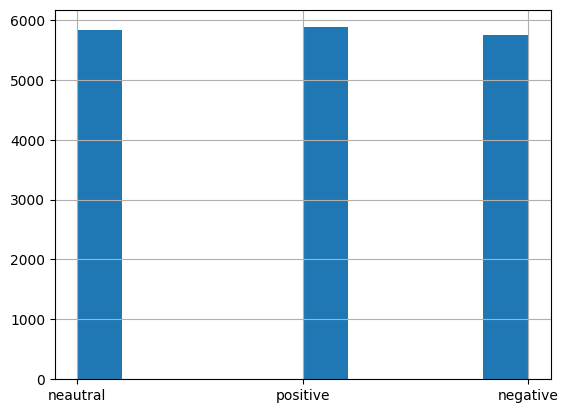

In [12]:
reviews_test_sample.sentiment.hist()
plt.show()

In [13]:
reviews_sentiment_map = {
    'negative': 0,
    'neautral': 1,
    'positive': 2
}

In [14]:
reviews_test_sample.sentiment = reviews_test_sample.sentiment\
    .apply(lambda x: reviews_sentiment_map[x])
reviews_test_sample.head(10)

,review,sentiment
45140,"Ехала долго посылка, больше полутора месяца. Д...",1
82647,Очень красивый и приятный на ощупь)),2
39454,"нитки торчат, прошито очень неаккуратно",1
71219,Доставка быстрая. По размеру подошло 46 р-р. Т...,2
45132,Пахнет,1
72801,"Отлично всё - пошив, качество, фасон. Брала сп...",2
67107,"Пришли за три недели, на 39 идеально!!! Понрав...",2
1487,Плохое качество и велик размер S. Хотя у меня ...,0
9131,Прошло 4 месяца с продом.продлевали защиту тов...,0
3752,Товар так и не пришел! Пришел подарок от продо...,0


In [15]:
class SentimentAnalysisDataset(Dataset):
    def __init__(self, X, y, tokenizer=None, num_labels=3, max_length=2048):
        self.X = tokenizer(X.tolist(), 
                           truncation=True, 
                           padding=True,
                           return_tensors="pt",
                           max_length=max_length).to(device)
        self.y = torch.tensor(y.to_numpy(), dtype=torch.int64).to(device)
    
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return self.X.input_ids[idx], self.X.attention_mask[idx], self.y[idx]

In [16]:
X = reviews_test_sample.review
y = reviews_test_sample.sentiment

In [17]:
tokenizer.pad_token_id = 0
rubert_tokenizer.pad_token_id = 0
print(tokenizer.pad_token)
print(rubert_tokenizer.pad_token)

<pad>
[PAD]


In [18]:
reviews_test_dataset = SentimentAnalysisDataset(X, y, tokenizer)
rubert_reviews_test_dataset = SentimentAnalysisDataset(X, y, rubert_tokenizer, 
                                                       max_length=512)

free_memory()

In [19]:
reviews_test_loader = DataLoader(reviews_test_dataset, batch_size=32)
rubert_reviews_test_loader = DataLoader(rubert_reviews_test_dataset, batch_size=32)

In [20]:
def evaluate_model(model, data_loader):
    ground_truth = []
    predictions = []

    model.eval()
    for input_ids, attention_mask, labels in data_loader:
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        labels = labels.to(device)
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = torch.mean(outputs.logits, dim=1)
        _, indices = torch.max(logits, 1)
        predictions.extend(indices.tolist())
        ground_truth.extend(labels.tolist())
        del input_ids
        del attention_mask
        del labels
        del outputs
        del logits
        del indices
        free_memory()
    accuracy = accuracy_score(ground_truth, predictions)
    f1 = f1_score(ground_truth, predictions, average='macro')
    del predictions
    del ground_truth
    free_memory()
    return accuracy, f1

In [21]:
def evaluate_bert_model(model, data_loader):
    ground_truth = []
    predictions = []

    model.eval()
    for input_ids, attention_mask, labels in data_loader:
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        labels = labels.to(device)
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        _, indices = torch.max(outputs.logits, 1)
        predictions.extend(indices.tolist())
        ground_truth.extend(labels.tolist())
        del input_ids
        del attention_mask
        del labels
        del outputs
        del indices
        free_memory()
    accuracy = accuracy_score(ground_truth, predictions)
    f1 = f1_score(ground_truth, predictions, average='macro')
    del predictions
    del ground_truth
    free_memory()
    return accuracy, f1

In [22]:
%%time
accuracy, f1 = evaluate_model(lt_model, reviews_test_loader)
print(f"Reviews test accuracy from large text model is {accuracy}")
print(f"Reviews test f1 score from large text model is {f1}")

Reviews test accuracy from large text model is 0.4852840128263857
Reviews test f1 score from large text model is 0.48834310344720455
CPU times: user 7min 42s, sys: 59.5 s, total: 8min 41s
Wall time: 8min 43s


In [23]:
%%time
accuracy, f1 = evaluate_model(st_model, reviews_test_loader)
print(f"Reviews test accuracy from small text model is {accuracy}")
print(f"Reviews test f1 score from small text model is {f1}")

Reviews test accuracy from small text model is 0.7238318827301878
Reviews test f1 score from small text model is 0.7217606786663741
CPU times: user 7min 42s, sys: 59.5 s, total: 8min 41s
Wall time: 8min 41s


In [24]:
%%time
accuracy, f1 = evaluate_model(st_medium_model, reviews_test_loader)
print(f"Reviews test accuracy from small text medium sized model is {accuracy}")
print(f"Reviews test f1 score from small text medium sized model is {f1}")

Reviews test accuracy from small text medium sized model is 0.7186211635364178
Reviews test f1 score from small text medium sized model is 0.7154217127279076
CPU times: user 19min 38s, sys: 1min 43s, total: 21min 21s
Wall time: 21min 20s


In [25]:
%%time
accuracy, f1 = evaluate_bert_model(st_rubert, rubert_reviews_test_loader)
print(f"Reviews test accuracy from small text RuBert is {accuracy}")
print(f"Reviews test f1 score from small text RuBert is {f1}")

Reviews test accuracy from small text RuBert is 0.6501946862116353
Reviews test f1 score from small text RuBert is 0.6474060214332357
CPU times: user 5min 20s, sys: 11.4 s, total: 5min 31s
Wall time: 5min 31s


In [26]:
%%time
accuracy, f1 = evaluate_bert_model(lt_rubert, rubert_reviews_test_loader)
print(f"Reviews test accuracy from large text RuBert is {accuracy}")
print(f"Reviews test f1 score from large text RuBert is {f1}")

Reviews test accuracy from large text RuBert is 0.5128263857077416
Reviews test f1 score from large text RuBert is 0.5064336058420454
CPU times: user 5min 19s, sys: 11.4 s, total: 5min 30s
Wall time: 5min 30s


In [27]:
articles = pd.read_json('data/articles/train.json')
articles.head(10)

,text,id,sentiment
0,Досудебное расследование по факту покупки ЕНПФ...,1945,negative
1,Медики рассказали о состоянии пострадавшего му...,1957,negative
2,"Прошел почти год, как железнодорожным оператор...",1969,negative
3,По итогам 12 месяцев 2016 года на территории р...,1973,negative
4,Астана. 21 ноября. Kazakhstan Today - Агентств...,1975,negative
5,Об аресте бывшего министра национальной эконом...,1980,negative
6,Двое налетчиков совершили нападение на охранни...,1982,negative
7,"""Самрук-Энерго"" в I квартале почти вдвое снизи...",1983,negative
8,В 2016 году почти половина коррупционных прест...,1985,negative
9,Google+\nЧт 19 янв 2017 12:35:02\nОдин из фигу...,1988,negative


In [28]:
articles_test_sample = articles.sample(2056, random_state=42)
articles_test_sample.head(10)

,text,id,sentiment
5176,В немецком городе Гамбург состоялся экономичес...,7230,neutral
5418,Глава правительства Бакытжан Сагинтаев провел ...,7472,neutral
856,"В среду, 25 января, первый заместитель п...",2910,positive
8200,"Kapital.kz 19 января 2017, 17:11 \n\nkapital.k...",10254,positive
1793,Высококачественные подделки тенге в Казахстане...,3847,neutral
7678,"Все отрасли ТЭК. Россия и Мир 20:41, 5.1.17 \n...",9732,neutral
4840,"\nКАЗАНЬ, 7 октября. /Корр. ТАСС Алексей Угаро...",6894,positive
5576,О реализации инвестпроектов в агропромышленном...,7630,neutral
7326,Ранее торговый центр был выставлен на торги че...,9380,neutral
5351,Алматы. 26 декабря. Центр информации. Руководс...,7405,positive


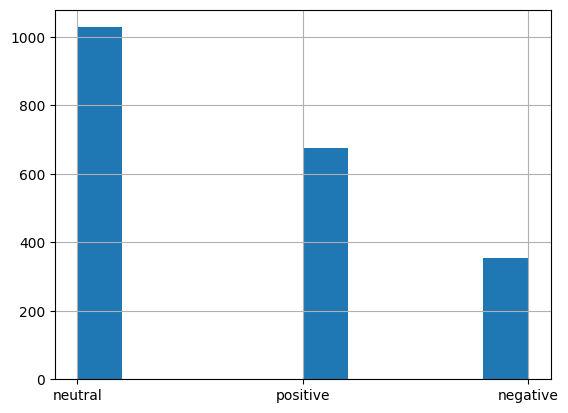

In [29]:
articles_test_sample.sentiment.hist()
plt.show()

In [30]:
articles_test_sample.sentiment = articles_test_sample.sentiment\
    .apply(lambda x: sentiment_map[x])
articles_test_sample.head(10)

,text,id,sentiment
5176,В немецком городе Гамбург состоялся экономичес...,7230,1
5418,Глава правительства Бакытжан Сагинтаев провел ...,7472,1
856,"В среду, 25 января, первый заместитель п...",2910,2
8200,"Kapital.kz 19 января 2017, 17:11 \n\nkapital.k...",10254,2
1793,Высококачественные подделки тенге в Казахстане...,3847,1
7678,"Все отрасли ТЭК. Россия и Мир 20:41, 5.1.17 \n...",9732,1
4840,"\nКАЗАНЬ, 7 октября. /Корр. ТАСС Алексей Угаро...",6894,2
5576,О реализации инвестпроектов в агропромышленном...,7630,1
7326,Ранее торговый центр был выставлен на торги че...,9380,1
5351,Алматы. 26 декабря. Центр информации. Руководс...,7405,2


In [31]:
X_articles_test = articles_test_sample.text
y_articles_test = articles_test_sample.sentiment

In [32]:
articles_test_dataset = SentimentAnalysisDataset(X_articles_test, y_articles_test, 
                                                 tokenizer)
rubert_articles_test_dataset = SentimentAnalysisDataset(X_articles_test, y_articles_test, 
                                                 rubert_tokenizer, max_length=512)

free_memory()

In [33]:
articles_test_loader = DataLoader(articles_test_dataset, batch_size=10)
rubert_articles_test_loader = DataLoader(rubert_articles_test_dataset, batch_size=10)

In [34]:
%%time
accuracy, f1 = evaluate_model(st_model, articles_test_loader)
print(f"Articles test accuracy from small text model is {accuracy}")
print(f"Articles test f1 score from small text model is {f1}")

Articles test accuracy from small text model is 0.49367704280155644
Articles test f1 score from small text model is 0.3540032465547715
CPU times: user 5min 23s, sys: 18.7 s, total: 5min 42s
Wall time: 5min 57s


In [35]:
%%time
accuracy, f1 = evaluate_model(lt_model, articles_test_loader)
print(f"Articles test accuracy from large text model is {accuracy}")
print(f"Articles test f1 score from large text model is {f1}")

Articles test accuracy from large text model is 0.7334630350194552
Articles test f1 score from large text model is 0.7267055779946027
CPU times: user 5min 24s, sys: 18.7 s, total: 5min 42s
Wall time: 5min 58s


In [36]:
%%time
accuracy, f1 = evaluate_bert_model(lt_rubert, rubert_articles_test_loader)
print(f"Articles test accuracy from large text RuBert is {accuracy}")
print(f"Articles test f1 score from large text RuBert is {f1}")

Articles test accuracy from large text RuBert is 0.6381322957198443
Articles test f1 score from large text RuBert is 0.5821312898429282
CPU times: user 1min 28s, sys: 2.8 s, total: 1min 31s
Wall time: 1min 31s


In [37]:
%%time
accuracy, f1 = evaluate_bert_model(st_rubert, rubert_articles_test_loader)
print(f"Articles test accuracy from small text RuBert is {accuracy}")
print(f"Articles test f1 score from small text RuBert is {f1}")

Articles test accuracy from small text RuBert is 0.5
Articles test f1 score from small text RuBert is 0.50463469503104
CPU times: user 1min 28s, sys: 2.78 s, total: 1min 31s
Wall time: 1min 31s


In [38]:
articles_test_loader = DataLoader(articles_test_dataset, batch_size=6)

In [39]:
%%time
accuracy, f1 = evaluate_model(st_medium_model, articles_test_loader)
print(f"Articles test accuracy from small text medium sized model is {accuracy}")
print(f"Articles test f1 score from small text medium sized model is {f1}")

Articles test accuracy from small text medium sized model is 0.4474708171206226
Articles test f1 score from small text medium sized model is 0.4100246130678619
CPU times: user 15min 3s, sys: 15.1 s, total: 15min 18s
Wall time: 15min 42s
